### Build reaction class and super-class models (LR, AP3 + agent feature FP) and validate with external test set A

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import utilsFunctions
import numpy as np
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)

# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

In [25]:
print(len(reaction_types))
print(len(names_rTypes))

50
87


Load the AP3 and agent feature fingerprint

In [4]:
infile = gzip.open(dataDir+"transformationFPs_MG2_agentFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_agentFeature, fp_agentMG2 = cPickle.load(infile)      
#         print(cls)
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3,fp_agentFeature])
    idx+=1
#     print(idx)
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Build sets of reaction classes and super-classes

In [5]:
reaction_classes = set(x.split('.')[0]+"."+x.split('.')[1] for x in reaction_types)
print(reaction_classes)
reaction_superclasses = set(x.split('.')[0] for x in reaction_types)
print(reaction_superclasses)

{'7.3', '6.2', '1.6', '9.3', '5.1', '3.3', '7.2', '10.1', '8.1', '3.4', '7.1', '1.8', '6.1', '6.3', '2.1', '7.9', '10.4', '1.7', '9.1', '1.2', '2.6', '2.3', '3.1', '2.2', '8.2', '2.7', '10.2', '1.3'}
{'6', '10', '9', '7', '1', '3', '8', '2', '5'}


#### Build the reaction class model

Split the FPs in training (20 %) and test data (80 %) per reaction class

In [6]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

fpsz=256
trainFps_AP3_agentFeature=[]
trainActs=[]
testFps_AP3_agentFeature=[]
testActs=[]

print('building fp collection')

rclasses=sorted(list(reaction_classes))
# print(rclasses)

for i,klass in enumerate(rclasses):
    actIds = [x for x in indices if (fps[x][2].split('.')[0]+"."+fps[x][2].split('.')[1])==klass]
    nActive = int(len(actIds)/5) # take 20% for training
#     print(actIds)
    for x in actIds[:nActive]:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        trainFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest
    
print(len(trainFps_AP3_agentFeature))
print(len(testFps_AP3_agentFeature))

building fp collection
10000
40000


Train the LR classifier

In [7]:
print('training model')
lr_cls =  LogisticRegression(max_iter=3000, solver = 'liblinear')
result_lr_cls = lr_cls.fit(trainFps_AP3_agentFeature,trainActs)

training model


Evaluate the class model

In [8]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(result_lr_cls, testFps_AP3_agentFeature, testActs, rclasses, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9771  0.9471  0.9619       1.2 Reductive amination
 1  0.9808  0.9655  0.9731       1.3 N-arylation with Ar-X
 2  0.9296  0.9242  0.9269       1.6 Heteroaryl N-alkylation
 3  0.9575  0.9752  0.9663       1.7 O-substitution
 4  0.9650  0.9602  0.9626       1.8 S-substitution
 5  0.9712  0.9733  0.9723      10.1 Halogenation
 6  0.9725  0.9962  0.9842      10.2 Nitration
 7  0.6275  0.8032  0.7046      10.4 Other functional group addition
 8  0.9842  0.9602  0.9720       2.1 N-acylation to amide
 9  0.9925  0.9975  0.9950       2.2 N-sulfonylation
10  0.9950  0.9925  0.9938       2.3 N-acylation to urea
11  0.9731  0.9202  0.9459       2.6 O-acylation to ester
12  0.9962  0.9975  0.9969       2.7 O-sulfonylation
13  0.9883  0.9933  0.9908       3.1 Suzuki coupling
14  0.9950  0.9938  0.9944       3.3 Sonogashira reaction
15  0.9762  0.9886  0.9824       3.4 Stille reaction
16  0.9225  0.9933  0.9566       5.1 NH protections
17  0.9958 

Draw the confusion matrix

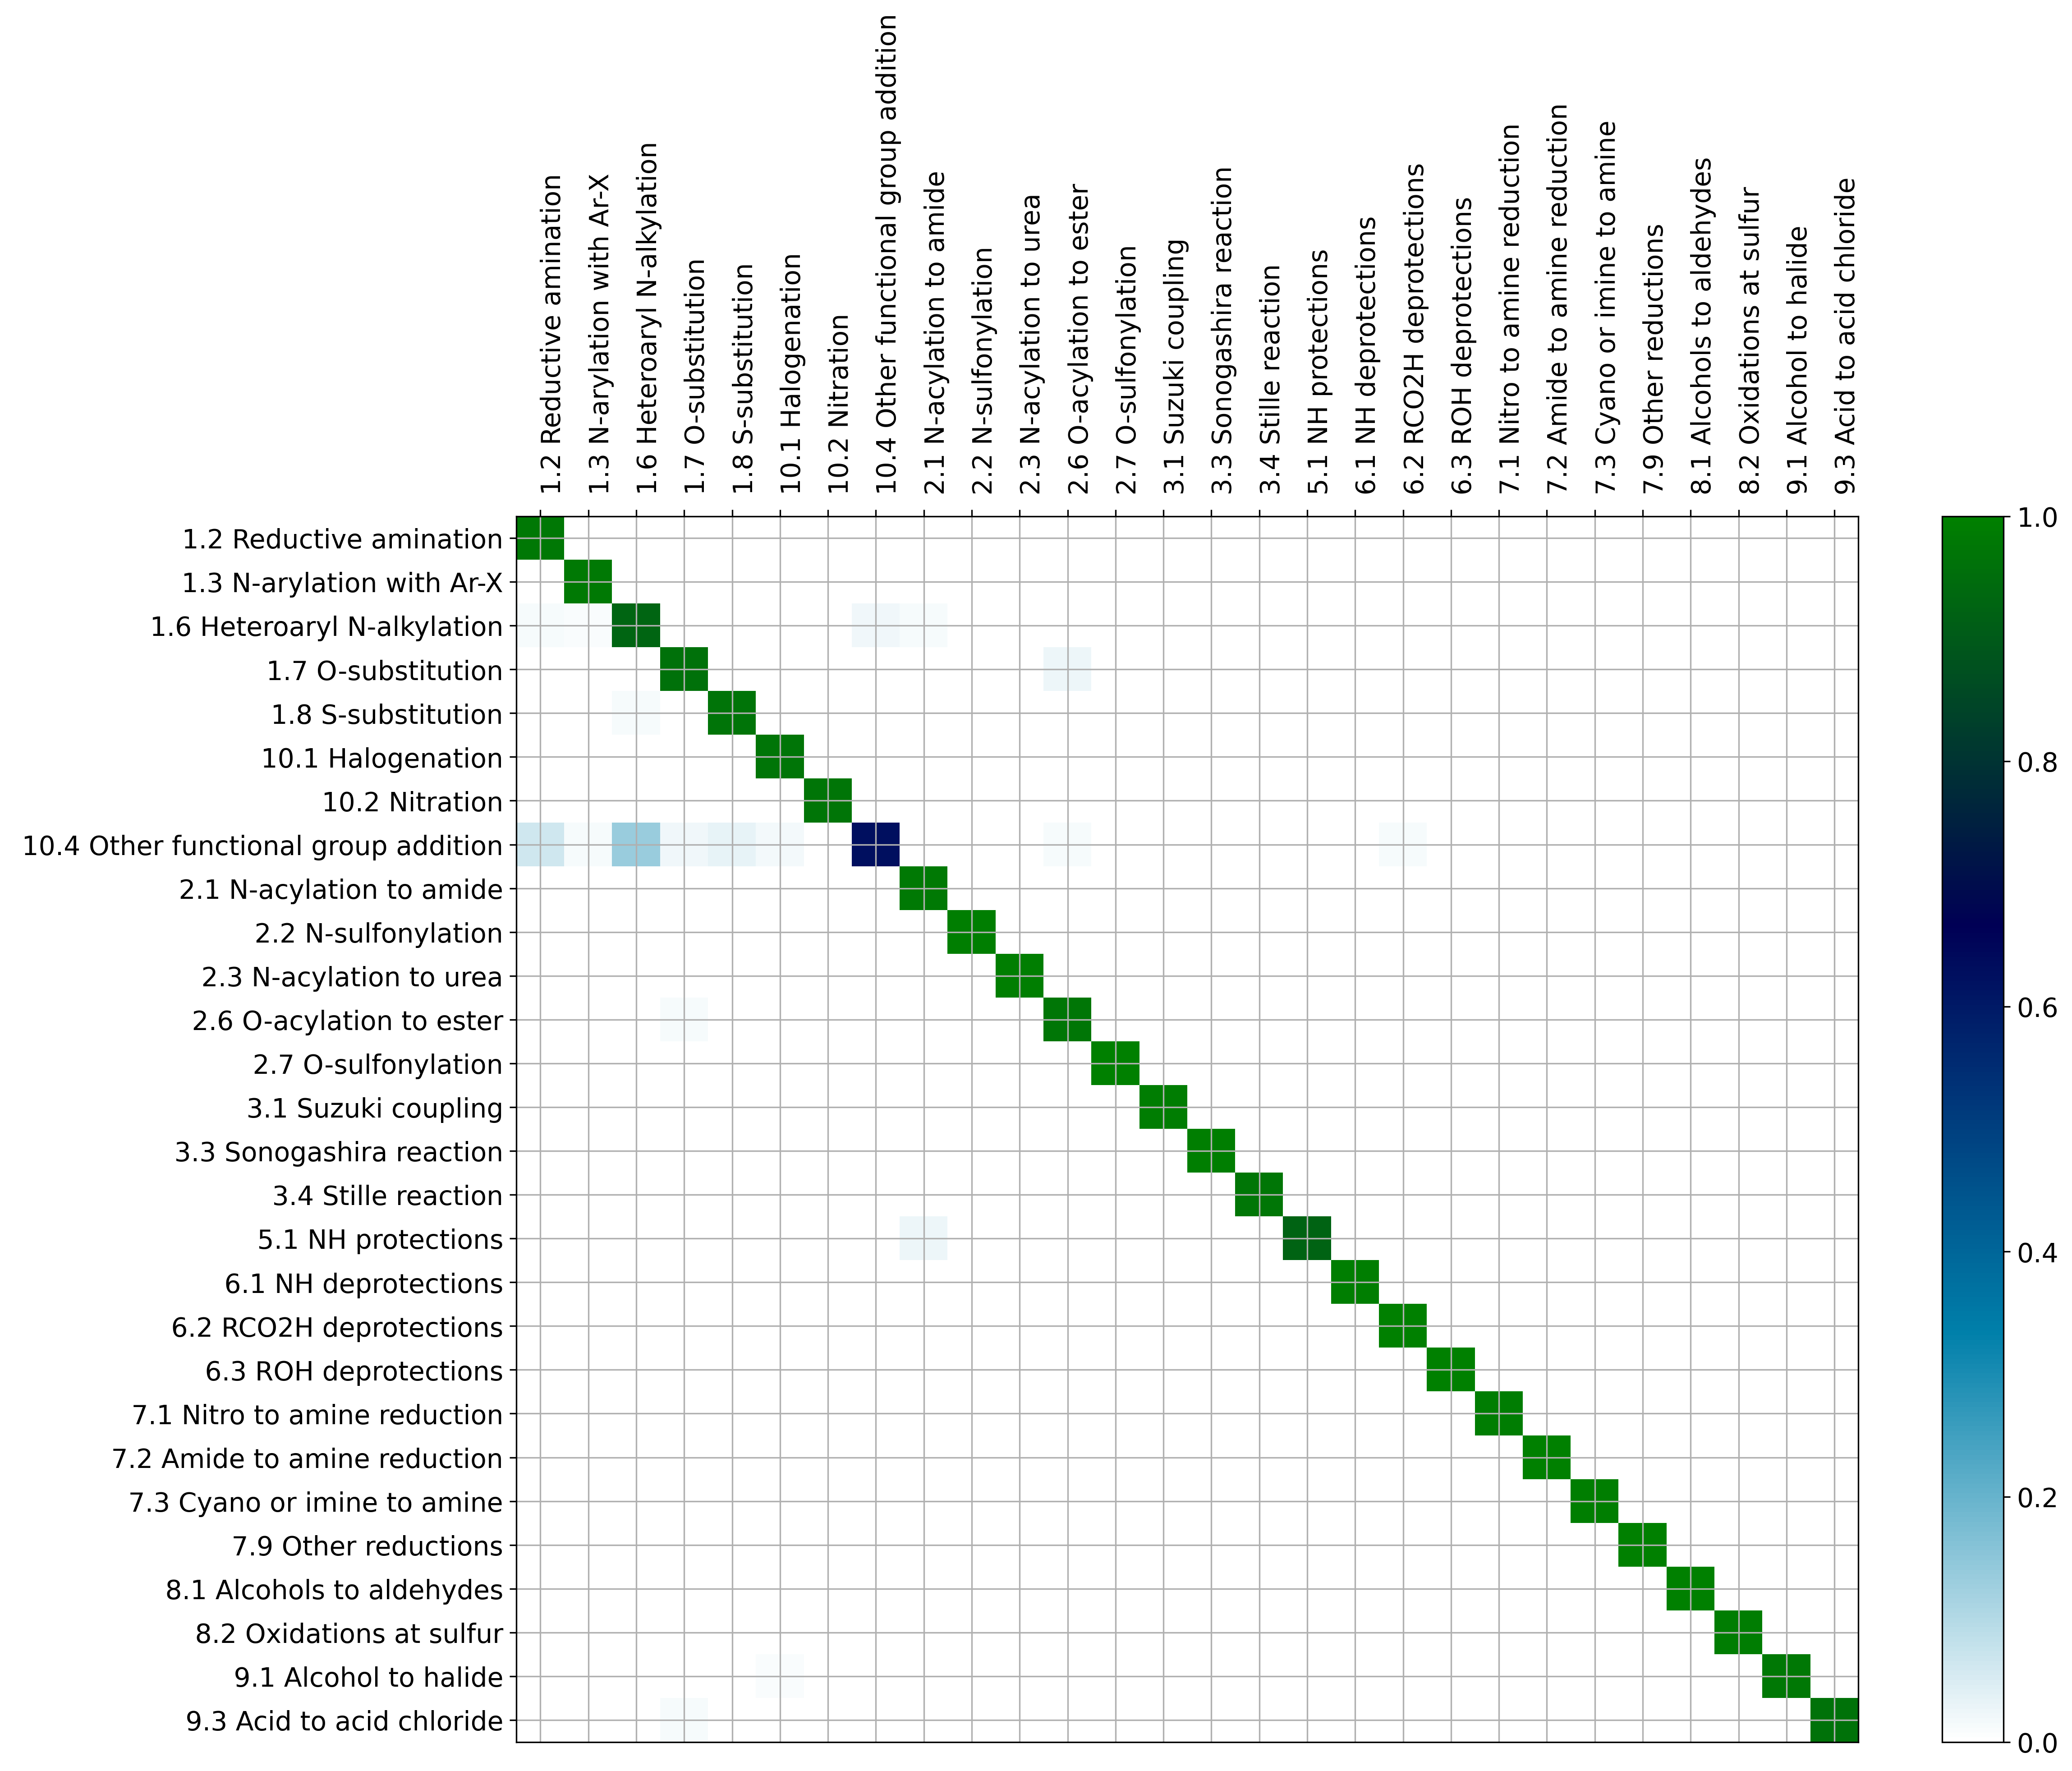

In [9]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rclasses,figsize=(16,12), labelExtras=names_rTypes)

In [10]:
import joblib

Store the model as scikit-learn model

In [11]:
joblib.dump(result_lr_cls, dataDir+'LR_transformationFP256bit.AP3.agent_featureFP_classModel.pkl') 

['../data/LR_transformationFP256bit.AP3.agent_featureFP_classModel.pkl']

#### Build the reaction super-class model

Split the FPs in training (20 %) and test data (80 %) per reaction super-class

In [12]:
import numpy as np

random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

fpsz=256
trainFps_AP3_agentFeature=[]
trainActs=[]
testFps_AP3_agentFeature=[]
testActs=[]

print('building fp collection')

rsclasses=sorted(list(reaction_superclasses))
for i,klass in enumerate(rsclasses):
    actIds = [x for x in indices if (fps[x][2].split('.')[0])==klass]
    nActive = int(len(actIds)/5) # take 20% for training
    for x in actIds[:nActive]:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        trainFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


Train the LR classifier 

In [13]:
print('training model')
lr_cls =  LogisticRegression(solver = 'liblinear')
result_lr_cls = lr_cls.fit(trainFps_AP3_agentFeature,trainActs)

training model


Evaluate the super-class model

In [14]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(result_lr_cls, testFps_AP3_agentFeature, testActs, rsclasses, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9647  0.9563  0.9605         1 Heteroatom alkylation and arylation
 1  0.8810  0.9506  0.9145        10 Functional group addition (FGA)
 2  0.9805  0.9538  0.9669         2 Acylation and related processes
 3  0.9875  0.9915  0.9895         3 C-C bond formation
 4  0.9163  0.9919  0.9526         5 Protections
 5  0.9977  0.9915  0.9945         6 Deprotections
 6  0.9969  0.9794  0.9881         7 Reductions
 7  0.9929  0.9892  0.9911         8 Oxidations
 8  0.9794  0.9880  0.9837         9 Functional group interconversion (FGI)
Mean: 0.97    0.98    0.97


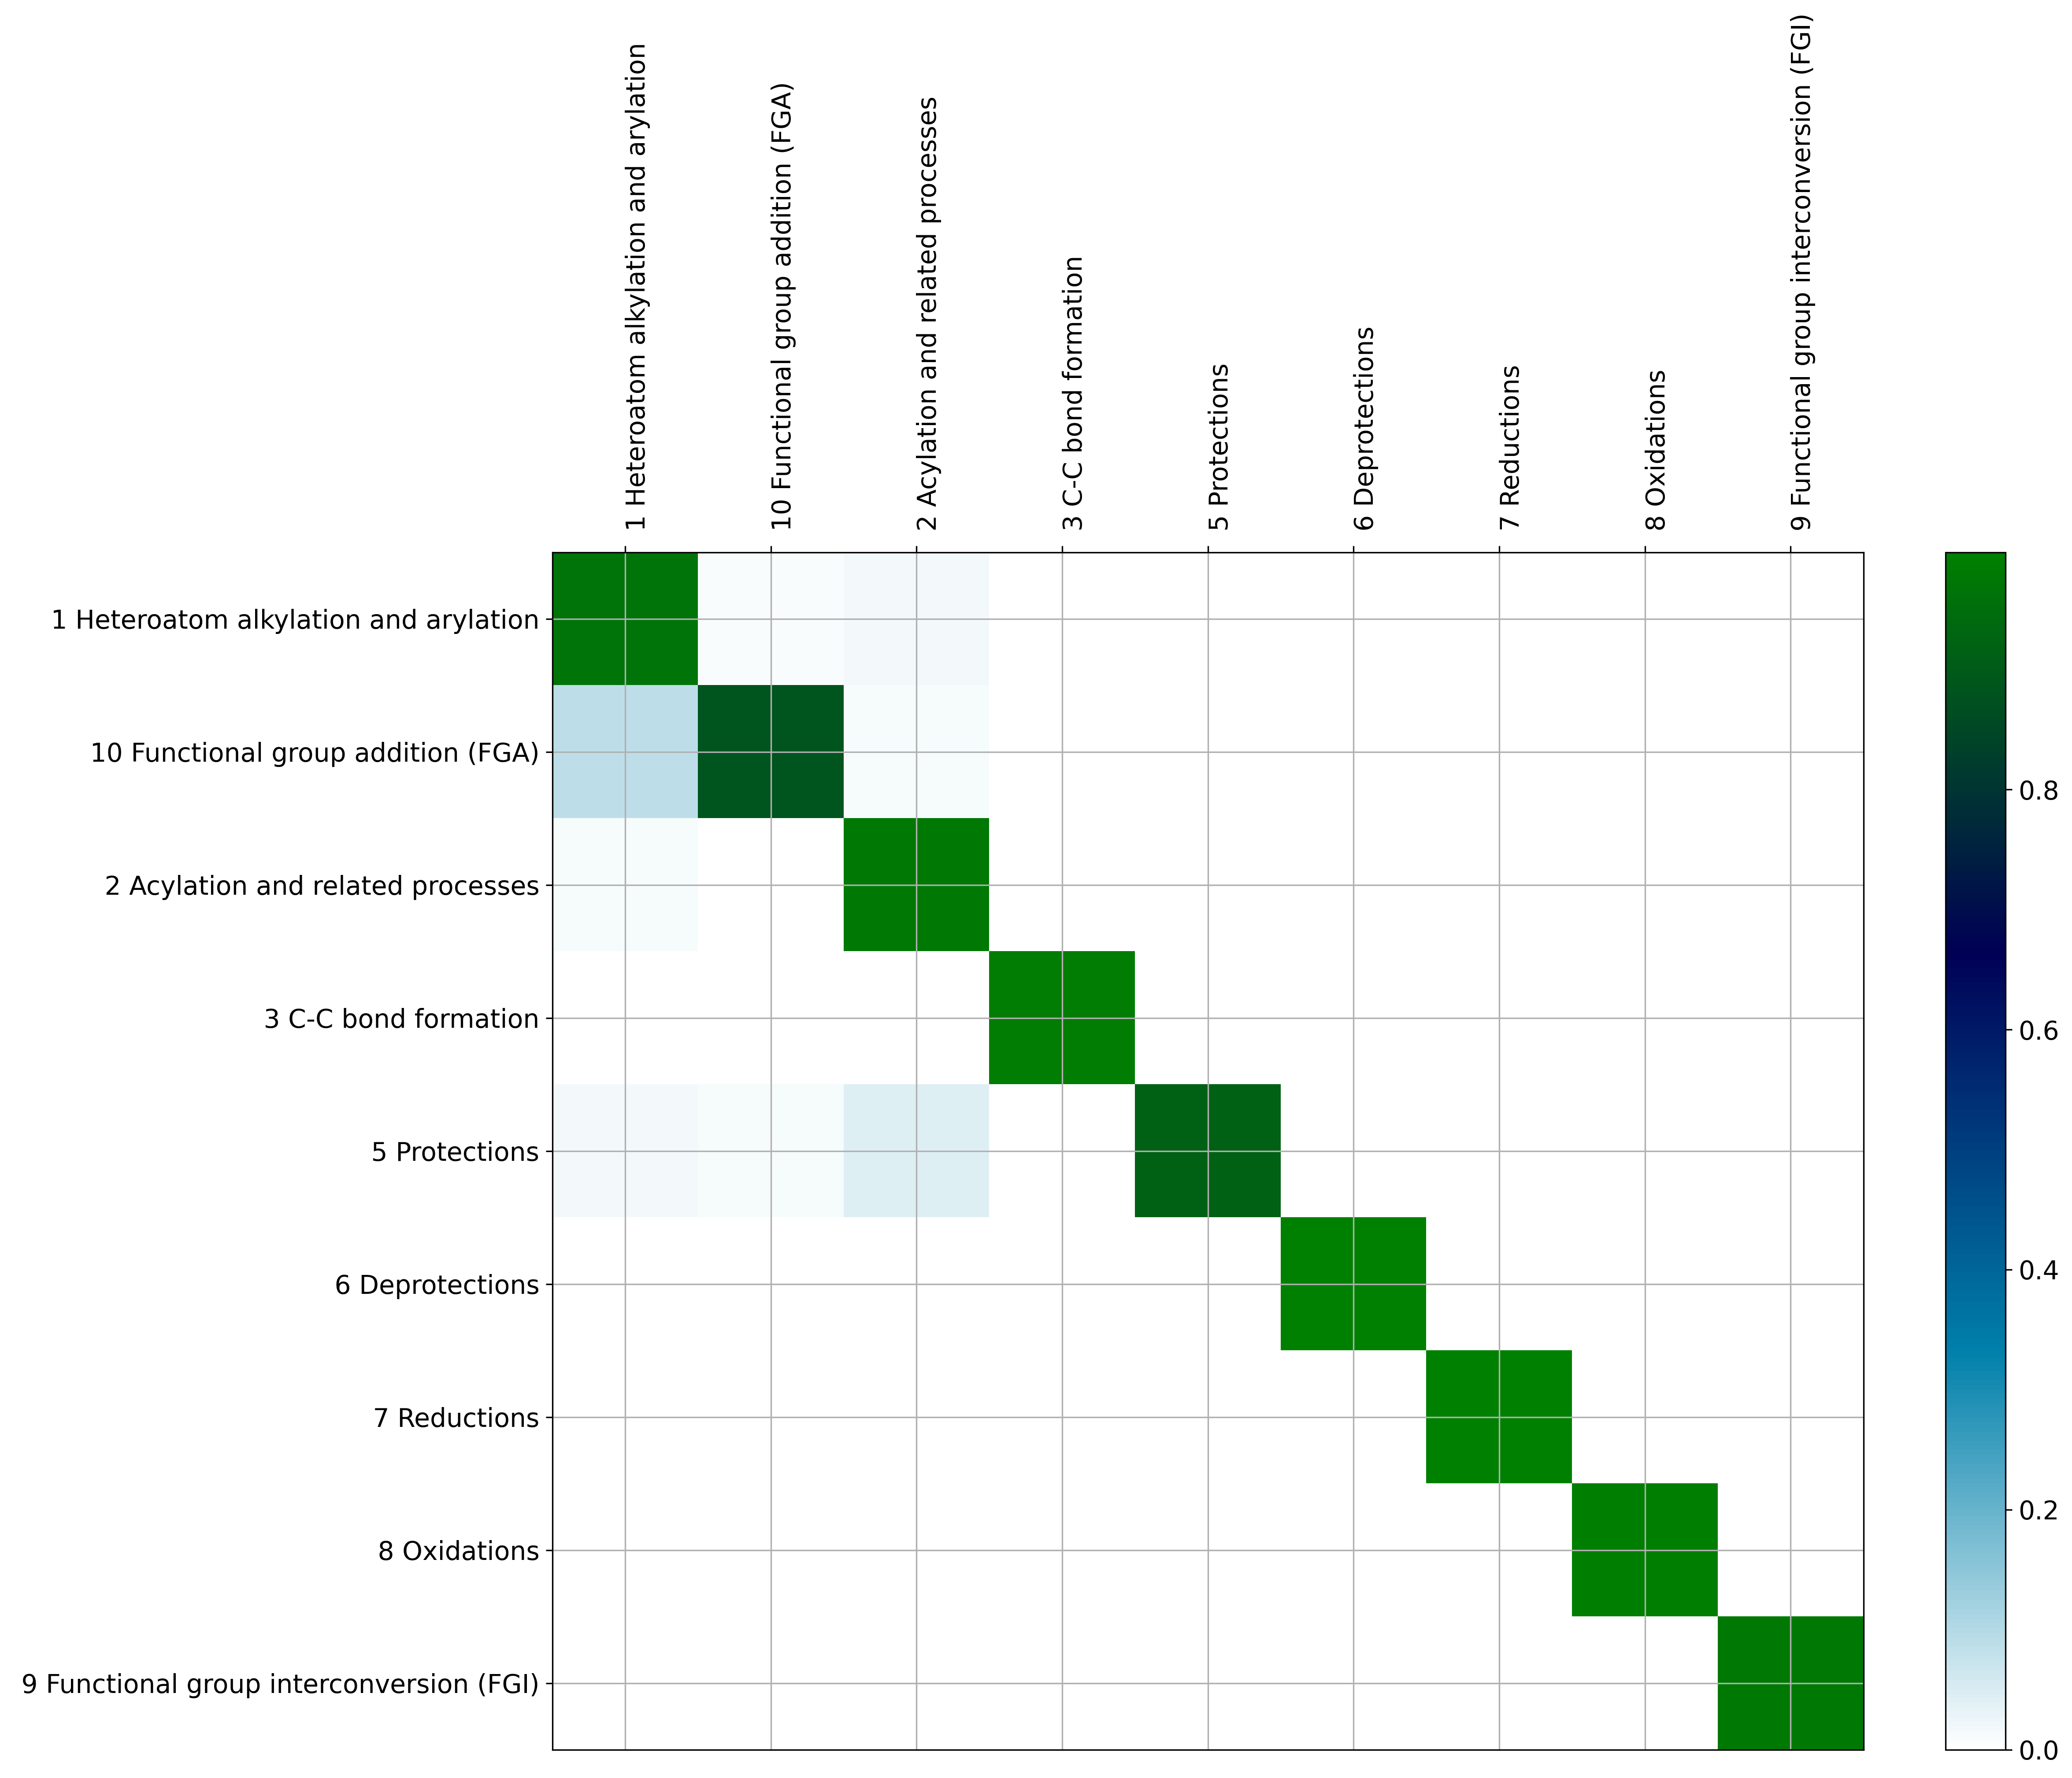

In [15]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rsclasses,figsize=(16,12), labelExtras=names_rTypes)

Store the model as scikit-learn model

In [16]:
joblib.dump(result_lr_cls, dataDir+'LR_transformationFP256bit.AP3.agent_featureFP_superclassModel.pkl') 

['../data/LR_transformationFP256bit.AP3.agent_featureFP_superclassModel.pkl']

#### Load the new models and test on external test set A

In [39]:
clf1 = joblib.load(dataDir+'LR_transformationFP256bit.AP3.agent_featureFP_classModel.pkl')
clf2 = joblib.load(dataDir+'LR_transformationFP256bit.AP3.agent_featureFP_superclassModel.pkl')

Load the fingerprints of external test set A, another 50000 reactions randomly selected form the patent data

In [40]:
infile = gzip.open(dataDir+"transformationFPs_agentFPs_external_test_set_A.pkl.gz", 'rb')
lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,apfp_woA,agent_feature = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,apfp_woA,agent_feature])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Combine the AP3 and agent feature FPs for the class model

In [41]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

fpsz=256

testFps_AP3_agentFeature=[]
testActs=[]
print('building fp collection')

rclasses=sorted(list(reaction_classes))
for i,klass in enumerate(rclasses):
    actIds = [x for x in indices if (fps[x][2].split('.')[0]+"."+fps[x][2].split('.')[1])==klass]
    nTest=len(actIds)
    for x in actIds:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


Validate the class model on the external test set

In [42]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(clf1, testFps_AP3_agentFeature, testActs, rclasses, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9820  0.9637  0.9728       1.2 Reductive amination
 1  0.9817  0.9688  0.9752       1.3 N-arylation with Ar-X
 2  0.9460  0.9479  0.9469       1.6 Heteroaryl N-alkylation
 3  0.9560  0.9706  0.9632       1.7 O-substitution
 4  0.9840  0.9781  0.9811       1.8 S-substitution
 5  0.9773  0.9767  0.9770      10.1 Halogenation
 6  0.9830  0.9970  0.9899      10.2 Nitration
 7  0.6750  0.8272  0.7434      10.4 Other functional group addition
 8  0.9840  0.9688  0.9764       2.1 N-acylation to amide
 9  0.9950  0.9970  0.9960       2.2 N-sulfonylation
10  0.9990  0.9950  0.9970       2.3 N-acylation to urea
11  0.9810  0.9277  0.9536       2.6 O-acylation to ester
12  0.9960  0.9970  0.9965       2.7 O-sulfonylation
13  0.9903  0.9920  0.9912       3.1 Suzuki coupling
14  0.9920  0.9970  0.9945       3.3 Sonogashira reaction
15  0.9810  0.9889  0.9849       3.4 Stille reaction
16  0.9390  0.9989  0.9680       5.1 NH protections
17  0.9970 

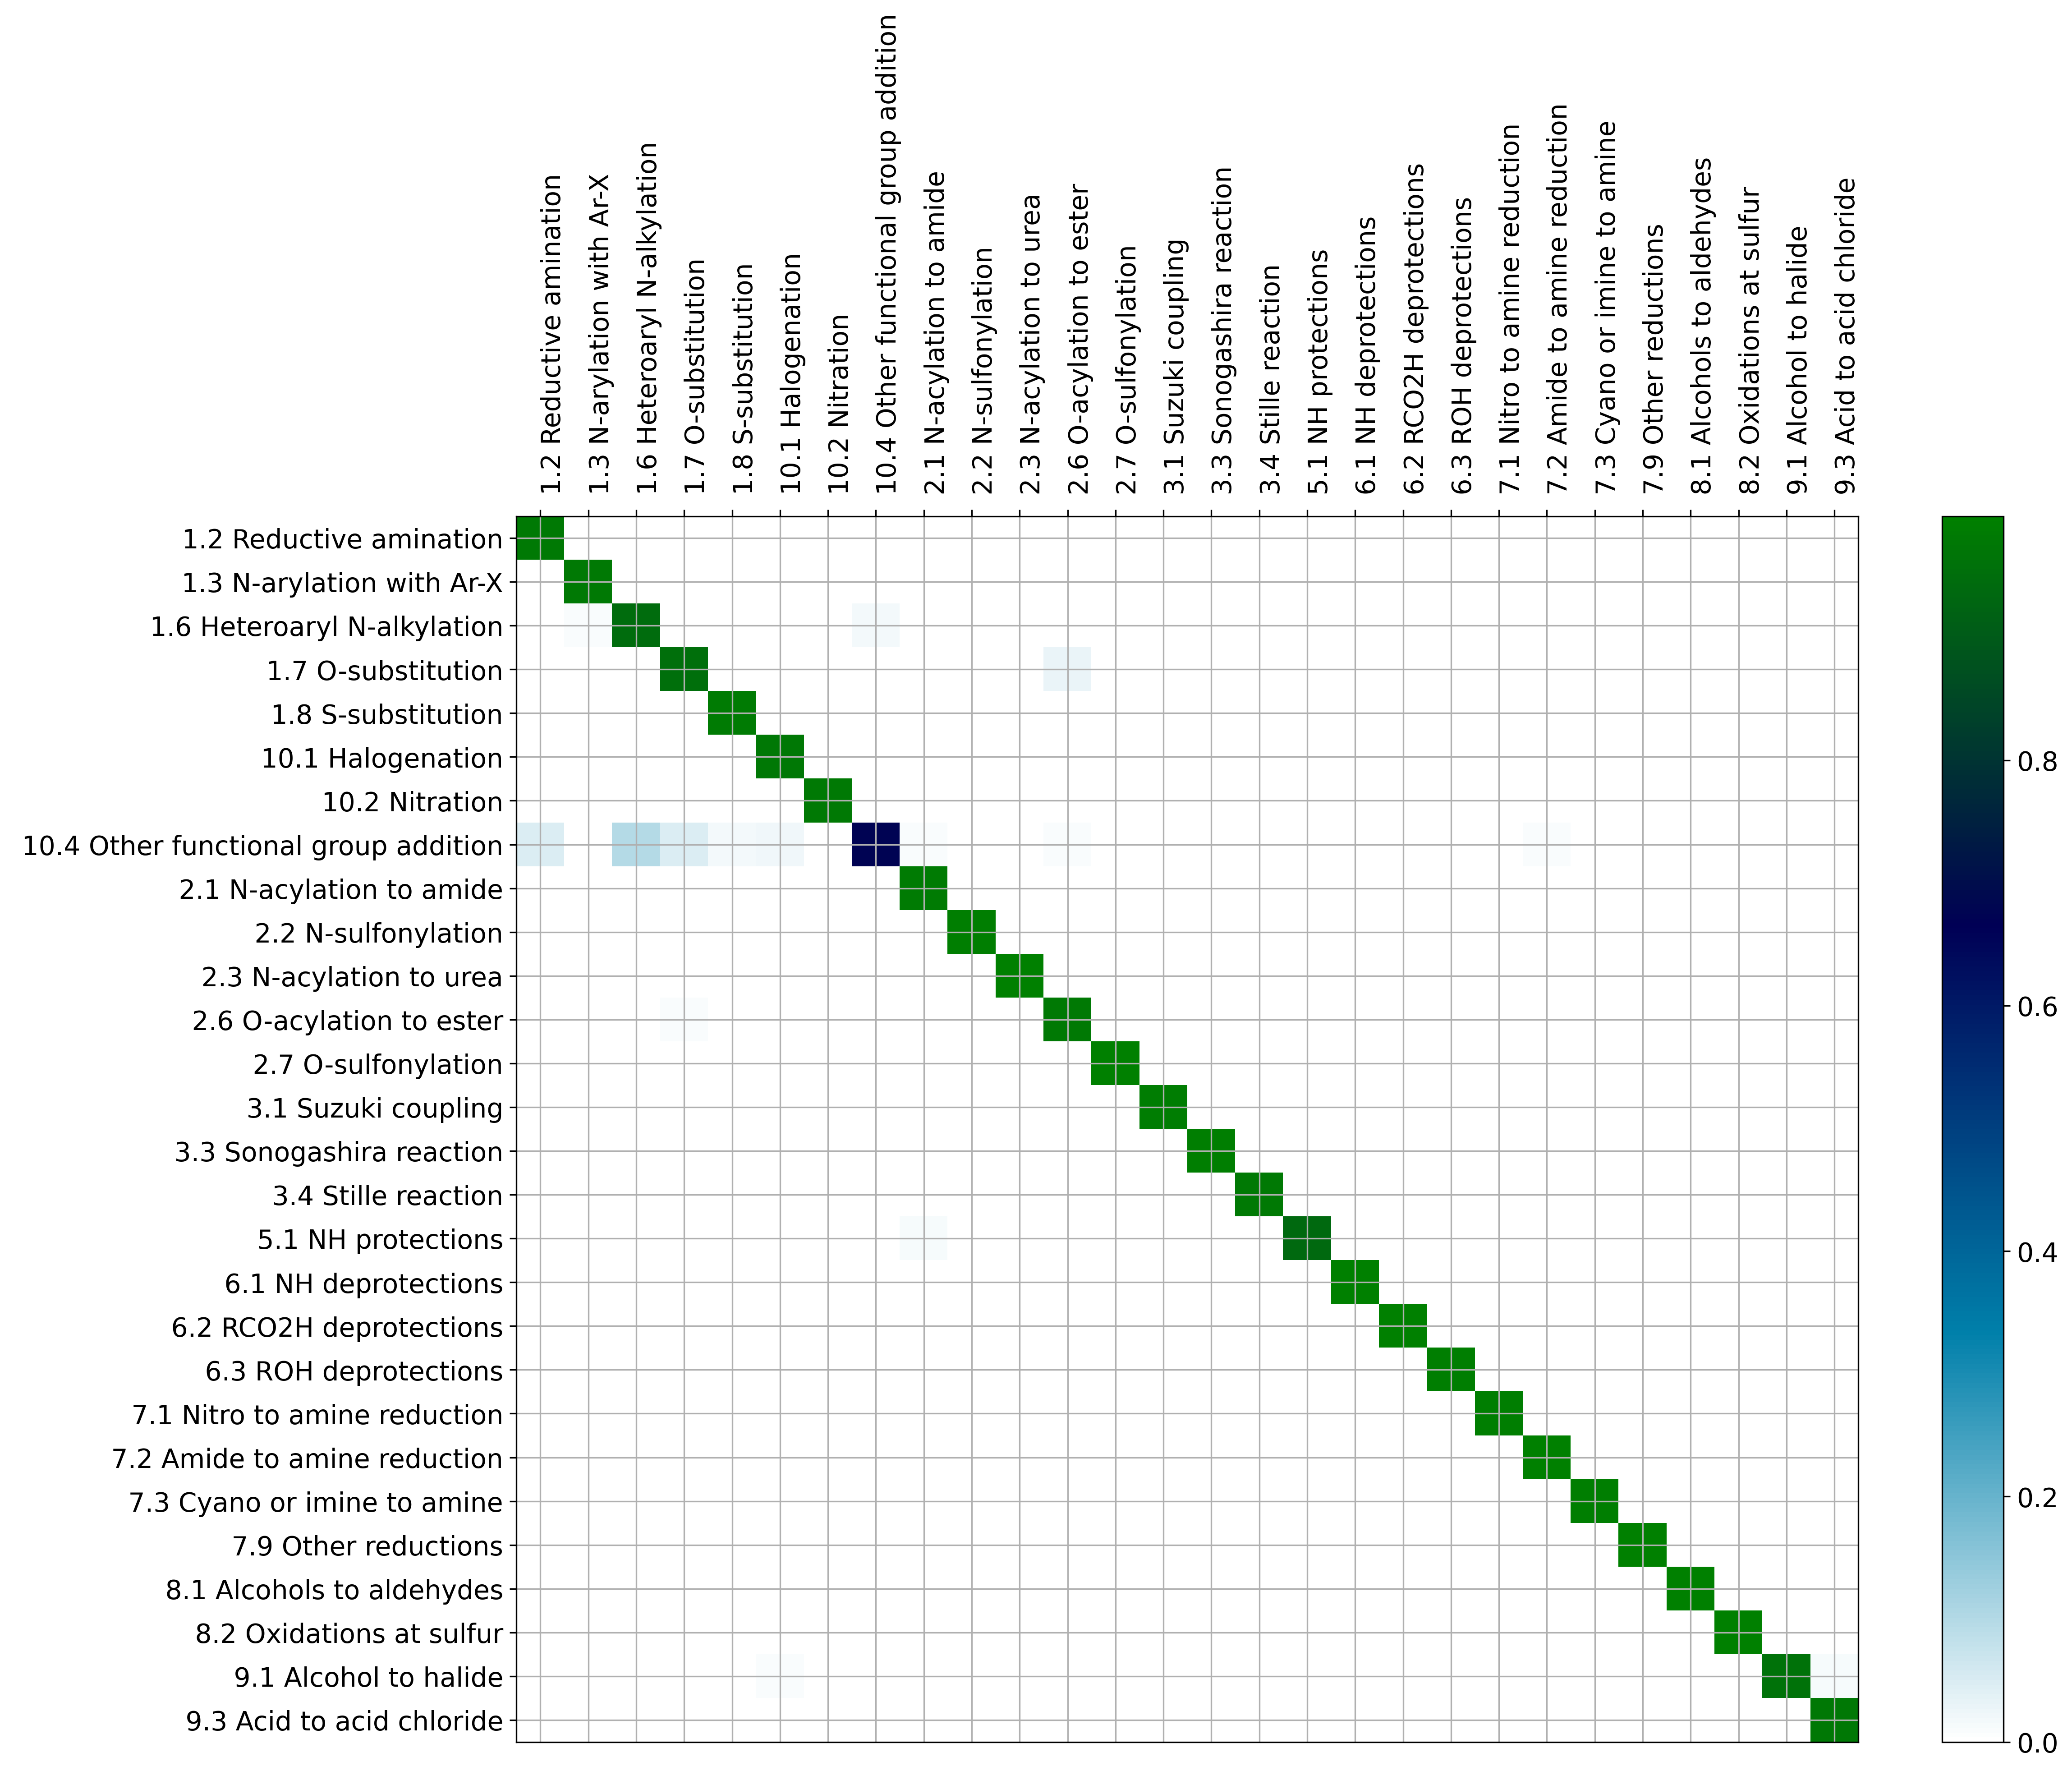

In [43]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rclasses,figsize=(16,12), labelExtras=names_rTypes)

Combine the AP3 and agent feature FPs for the super-class model

In [44]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

fpsz=256

testFps_AP3_agentFeature=[]
testActs=[]
print('building fp collection')

rsclasses=sorted(list(reaction_superclasses))
for i,klass in enumerate(rsclasses):
    actIds = [x for x in indices if (fps[x][2].split('.')[0])==klass]
    nTest=len(actIds)
    for x in actIds:
        np1 = utilsFunctions.fpToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_AP3_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


Validate the super-class model on the external test set

In [45]:
cmat_fp_AP3_feature = utilsFunctions.evaluateModel(clf2, testFps_AP3_agentFeature, testActs, rsclasses, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9699  0.9566  0.9632         1 Heteroatom alkylation and arylation
 1  0.8958  0.9579  0.9258        10 Functional group addition (FGA)
 2  0.9768  0.9629  0.9698         2 Acylation and related processes
 3  0.9886  0.9904  0.9895         3 C-C bond formation
 4  0.9290  0.9957  0.9612         5 Protections
 5  0.9972  0.9911  0.9941         6 Deprotections
 6  0.9965  0.9791  0.9877         7 Reductions
 7  0.9947  0.9907  0.9927         8 Oxidations
 8  0.9660  0.9867  0.9763         9 Functional group interconversion (FGI)
Mean: 0.97    0.98    0.97


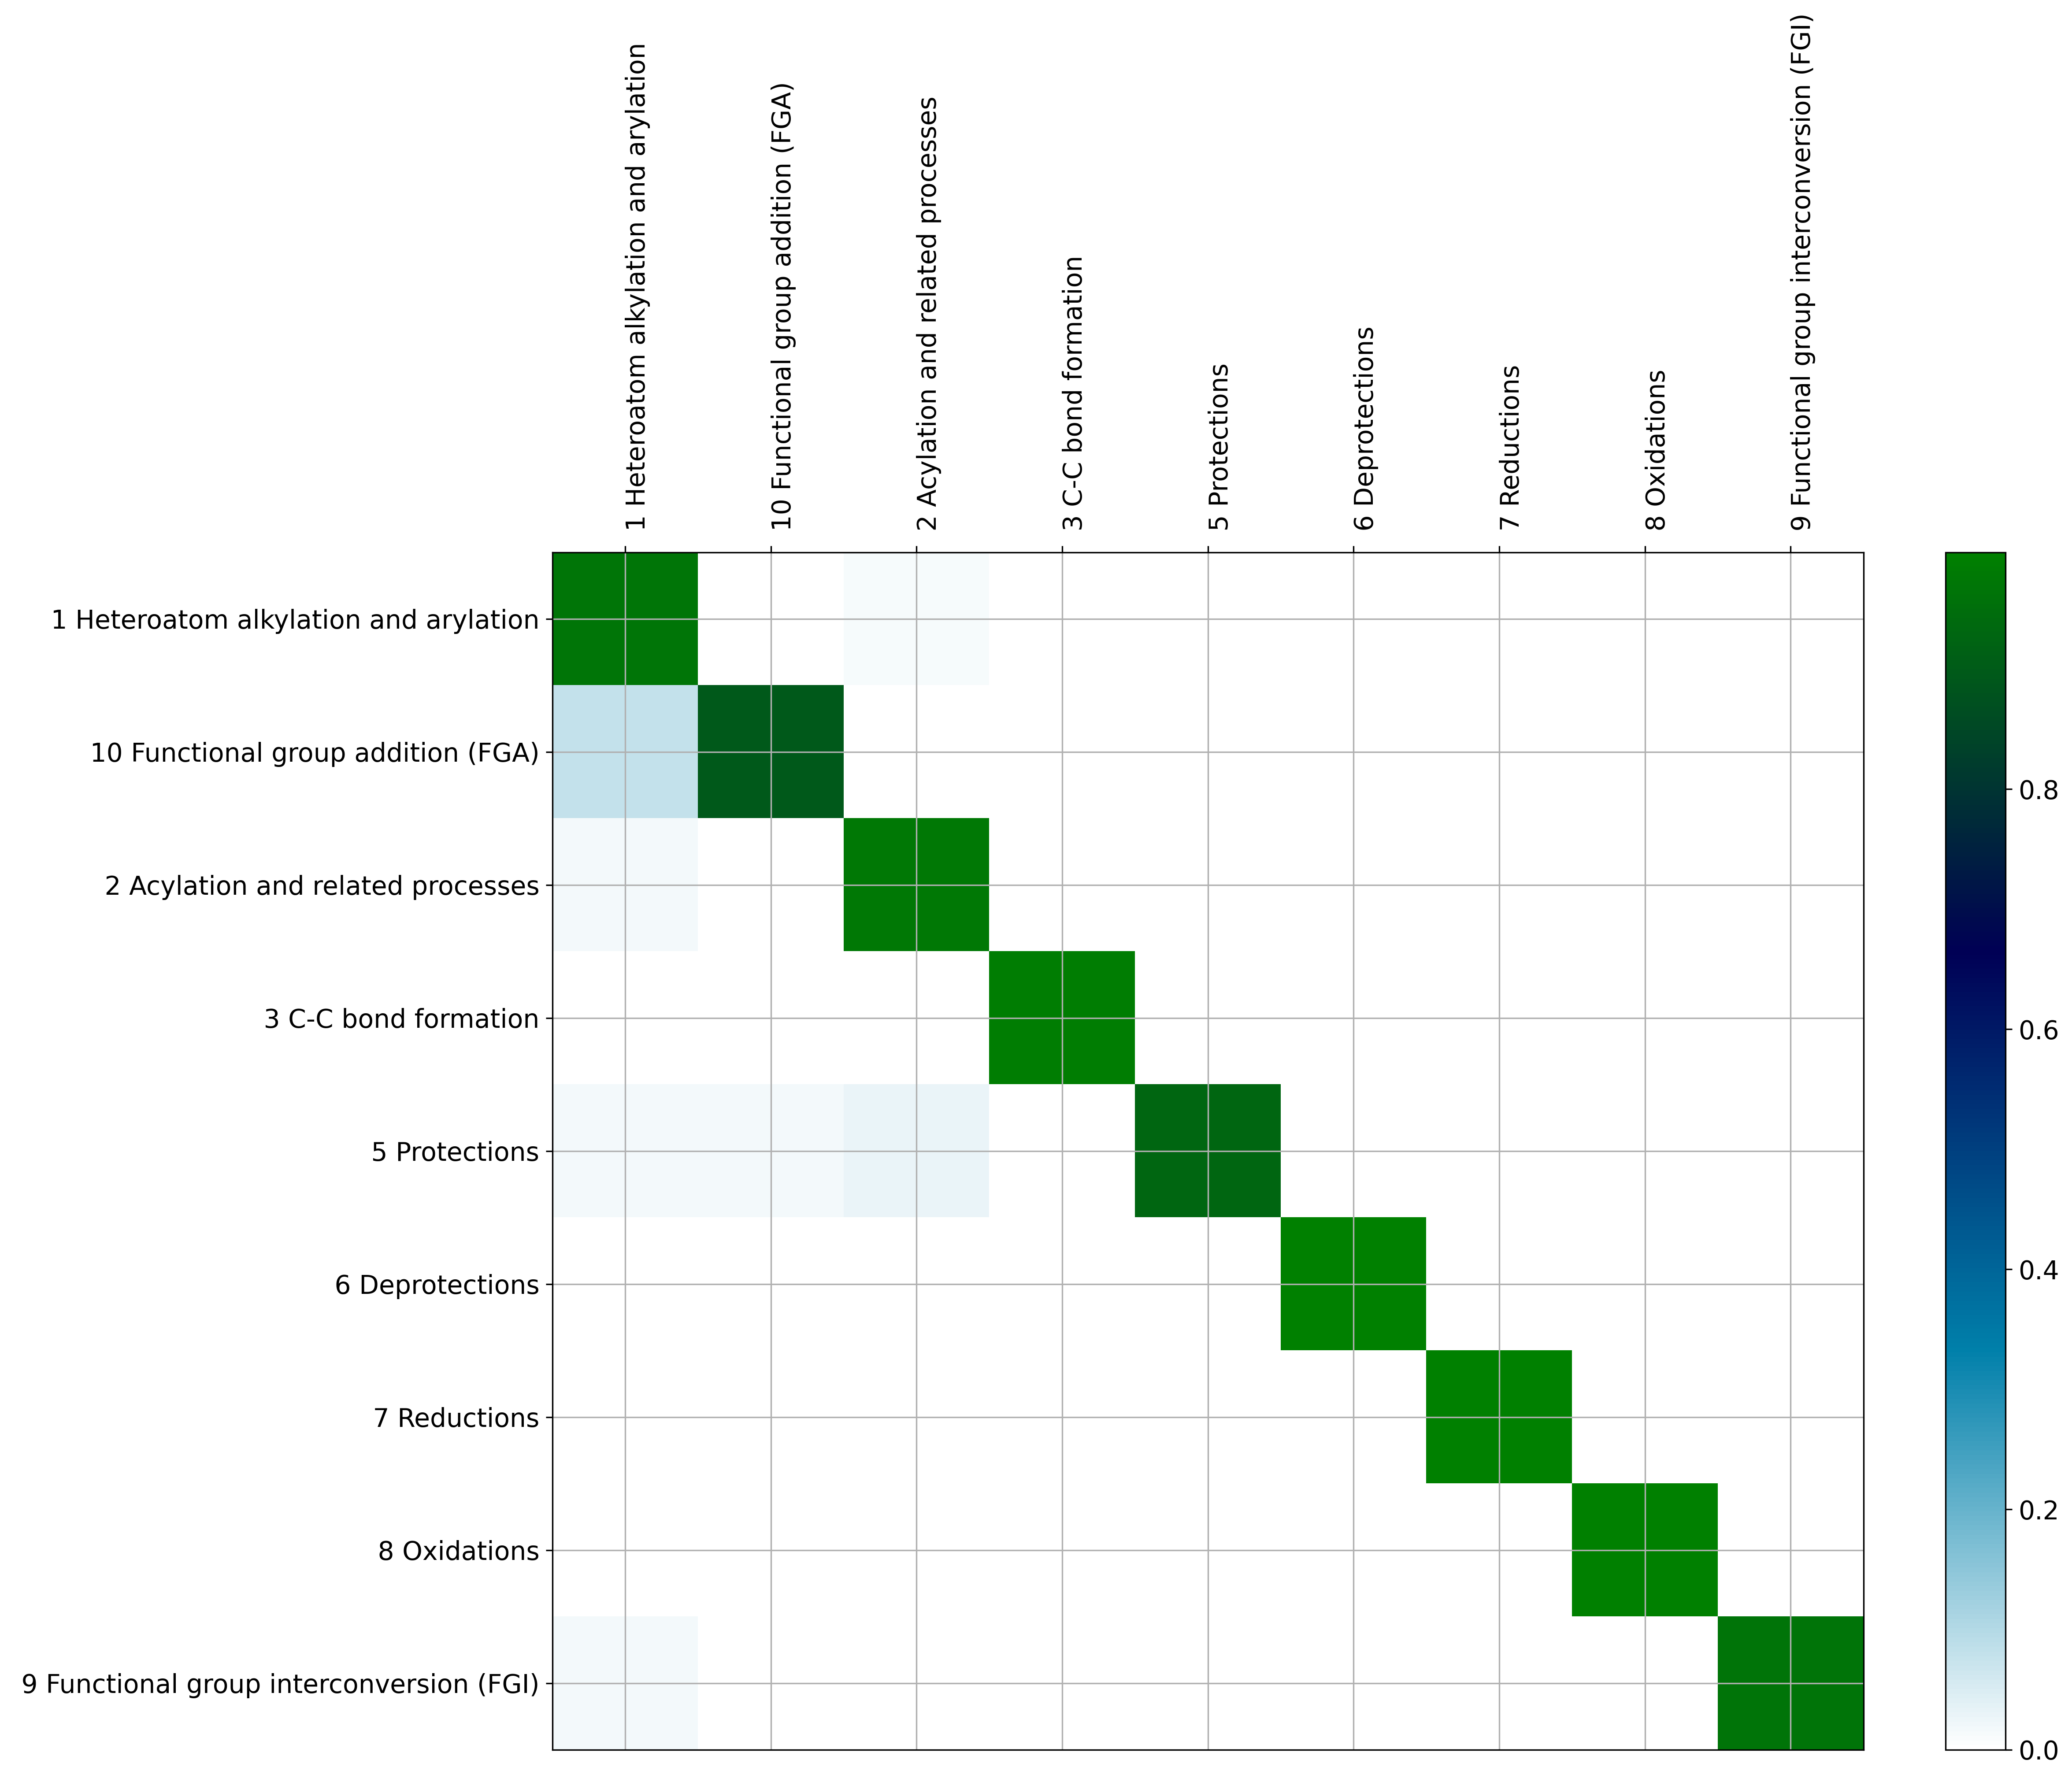

In [46]:
utilsFunctions.labelled_cmat(cmat_fp_AP3_feature,rsclasses,figsize=(16,12), labelExtras=names_rTypes)